# DAC Discrete Indices Visualization

This notebook explores the discrete token indices produced by DAC (Descript Audio Codec).

## What we're exploring:
- DAC encodes audio into 9 parallel codebooks
- Each codebook has 1024 possible values (indices 0-1023)
- We'll visualize how different words map to different token patterns

In [12]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Import our utilities
from dac_utils import DACProcessor, SpeechCommandsLoader, extract_dac_embeddings_batch

print("Imports successful!")

Imports successful!


## Step 1: Explore DAC Model Structure

In [13]:
# Initialize DAC processor (using 16khz for Speech Commands)
# Speech Commands dataset is 16kHz, so we'll use the 16kHz DAC model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

dac_processor = DACProcessor(model_type="16khz", device=device)

Using device: cuda
Loading DAC model (16khz)...


/home/amanag/videoEra/sound/wav2vec_vs_whisper/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning:

`torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.



Model loaded successfully!
  - Sample rate: 16000Hz
  - Codebooks: 12
  - Codebook size: 1024
  - Codebook dim: 8


In [14]:
# Explore model structure
model = dac_processor.model

print("=" * 60)
print("DAC MODEL STRUCTURE")
print("=" * 60)
print(f"Sample Rate: {model.sample_rate}Hz")
print(f"Hop Length: {model.hop_length} samples")
print(f"Latent Dim: {model.latent_dim}")
print(f"\nQuantizer:")
print(f"  - Number of codebooks: {model.n_codebooks}")
print(f"  - Codebook size: {model.codebook_size} entries")
print(f"  - Codebook dim: {model.codebook_dim}")
print(f"\nQuantizer Details:")
for i, quantizer in enumerate(model.quantizer.quantizers):
    print(f"  Codebook {i}:")
    print(f"    - Embedding shape: {quantizer.codebook.weight.shape}")
    print(f"    - in_proj: {quantizer.in_proj}")
    print(f"    - out_proj: {quantizer.out_proj}")
print("=" * 60)

DAC MODEL STRUCTURE
Sample Rate: 16000Hz
Hop Length: 320 samples
Latent Dim: 1024

Quantizer:
  - Number of codebooks: 12
  - Codebook size: 1024 entries
  - Codebook dim: 8

Quantizer Details:
  Codebook 0:
    - Embedding shape: torch.Size([1024, 8])
    - in_proj: Conv1d(1024, 8, kernel_size=(1,), stride=(1,))
    - out_proj: Conv1d(8, 1024, kernel_size=(1,), stride=(1,))
  Codebook 1:
    - Embedding shape: torch.Size([1024, 8])
    - in_proj: Conv1d(1024, 8, kernel_size=(1,), stride=(1,))
    - out_proj: Conv1d(8, 1024, kernel_size=(1,), stride=(1,))
  Codebook 2:
    - Embedding shape: torch.Size([1024, 8])
    - in_proj: Conv1d(1024, 8, kernel_size=(1,), stride=(1,))
    - out_proj: Conv1d(8, 1024, kernel_size=(1,), stride=(1,))
  Codebook 3:
    - Embedding shape: torch.Size([1024, 8])
    - in_proj: Conv1d(1024, 8, kernel_size=(1,), stride=(1,))
    - out_proj: Conv1d(8, 1024, kernel_size=(1,), stride=(1,))
  Codebook 4:
    - Embedding shape: torch.Size([1024, 8])
    - in_pr

## Step 2: Load Sample Audio and Inspect Outputs

In [15]:
# Load a single audio sample to understand the output format
loader = SpeechCommandsLoader()
file_paths, labels = loader.load_word_samples(['zero'], samples_per_word=1)

if len(file_paths) > 0:
    test_file = file_paths[0]
    print(f"Testing with: {test_file}")

    # Encode
    encoded = dac_processor.encode_audio(test_file)

    print("\nEncoded Output Shapes:")
    print(f"  codes: {encoded['codes'].shape}  # [batch, n_codebooks, time]")
    print(f"  latents: {encoded['latents'].shape}  # [batch, n_codebooks*dim, time]")
    print(f"  z: {encoded['z'].shape}  # [batch, latent_dim, time]")
    print(f"  audio_length: {encoded['audio_length']}")

    # Show sample codes
    codes = encoded['codes'][0]  # [n_codebooks, time]
    print(f"\nSample codes from first 5 time steps:")
    print(codes[:, :5].numpy())

    # Show code statistics
    print(f"\nCode Statistics:")
    print(f"  Min code value: {codes.min().item()}")
    print(f"  Max code value: {codes.max().item()}")
    print(f"  Unique codes per codebook:")
    for i in range(codes.shape[0]):
        unique = torch.unique(codes[i]).numel()
        print(f"    Codebook {i}: {unique} unique values")
else:
    print("No audio files found!")

Loaded 1 audio files from 1 words
Testing with: /data/aman/speech_commands/speech_commands_v0.02/zero/004ae714_nohash_0.wav

Encoded Output Shapes:
  codes: torch.Size([1, 12, 50])  # [batch, n_codebooks, time]
  latents: torch.Size([1, 96, 50])  # [batch, n_codebooks*dim, time]
  z: torch.Size([1, 1024, 50])  # [batch, latent_dim, time]
  audio_length: 16000

Sample codes from first 5 time steps:
[[ 163  640   40  163  759]
 [ 208  553  341  994  115]
 [ 841  262  908 1019  274]
 [ 980   73  167  288  467]
 [  53  803   37  134  102]
 [ 875  852  851 1022  715]
 [ 836  802  915  497  407]
 [ 196  917  202    6 1006]
 [  81   87  626  863  392]
 [ 161  848  651  499  619]
 [ 727  230  799   49  259]
 [ 801  860  359  518  114]]

Code Statistics:
  Min code value: 1
  Max code value: 1023
  Unique codes per codebook:
    Codebook 0: 31 unique values
    Codebook 1: 42 unique values
    Codebook 2: 49 unique values
    Codebook 3: 48 unique values
    Codebook 4: 48 unique values
    Cod

## Step 3: Load Dataset - 5 Words with 10 Samples Each

In [16]:
# Select 5 words for visualization
words = ['zero', 'one', 'two', 'yes', 'no']
samples_per_word = 10

# Load audio paths
file_paths, file_labels = loader.load_word_samples(words, samples_per_word=samples_per_word)

print(f"Total samples: {len(file_paths)}")
print(f"Label distribution:")
for word in words:
    count = file_labels.count(word)
    print(f"  {word}: {count} samples")

Loaded 50 audio files from 5 words
Total samples: 50
Label distribution:
  zero: 10 samples
  one: 10 samples
  two: 10 samples
  yes: 10 samples
  no: 10 samples


## Step 4: Extract Codes for All Samples

In [17]:
# Extract codes for all samples
all_codes = []
valid_labels = []

for file_path, label in zip(file_paths, file_labels):
    try:
        encoded = dac_processor.encode_audio(file_path)
        codes = encoded['codes'][0]  # [n_codebooks, time]
        all_codes.append(codes)
        valid_labels.append(label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print(f"\nSuccessfully processed {len(all_codes)} samples")
print(f"Code tensor shape (per sample): {all_codes[0].shape if all_codes else 'N/A'}")


Successfully processed 50 samples
Code tensor shape (per sample): torch.Size([12, 50])


## Step 5: Visualize Token Distributions

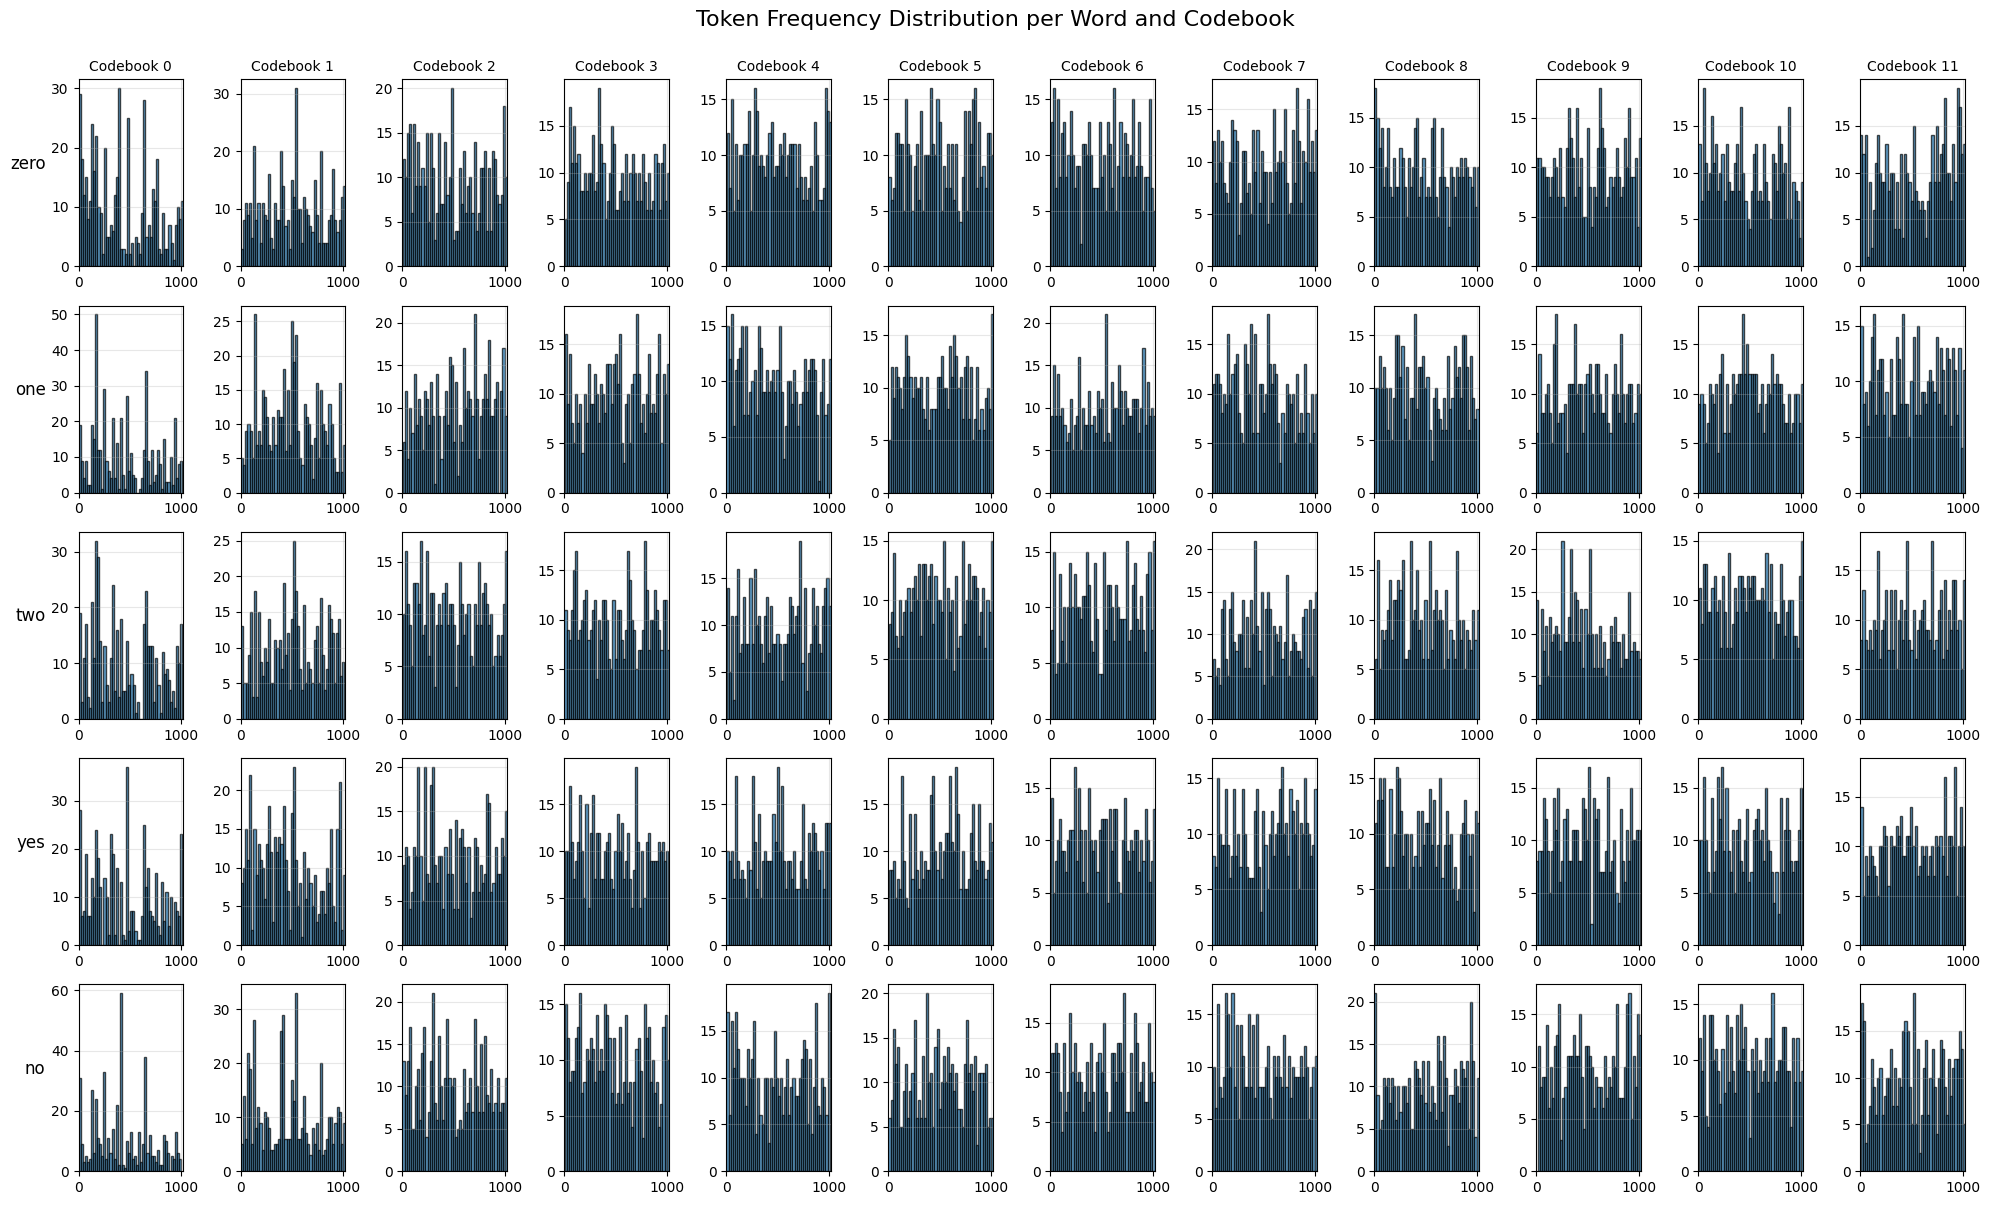

Saved: dac_token_distributions.png


In [18]:
# Create token frequency histograms per word
fig, axes = plt.subplots(len(words), model.n_codebooks, figsize=(20, 12))
fig.suptitle('Token Frequency Distribution per Word and Codebook', fontsize=16, y=1.00)

for word_idx, word in enumerate(words):
    # Get codes for this word
    word_codes = [all_codes[i] for i, label in enumerate(valid_labels) if label == word]
    
    if not word_codes:
        continue
    
    # Concatenate across time dimension
    word_codes_tensor = torch.cat(word_codes, dim=1)  # [n_codebooks, total_time]
    
    for codebook_idx in range(model.n_codebooks):
        ax = axes[word_idx, codebook_idx]
        
        # Get codes for this codebook
        codes = word_codes_tensor[codebook_idx].numpy()
        
        # Plot histogram
        ax.hist(codes, bins=50, alpha=0.7, edgecolor='black')
        
        if word_idx == 0:
            ax.set_title(f'Codebook {codebook_idx}', fontsize=10)
        if codebook_idx == 0:
            ax.set_ylabel(word, fontsize=12, rotation=0, ha='right')
        
        ax.set_xlim(0, model.codebook_size)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dac_token_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: dac_token_distributions.png")

## Step 6: Temporal Token Patterns (Heatmap)

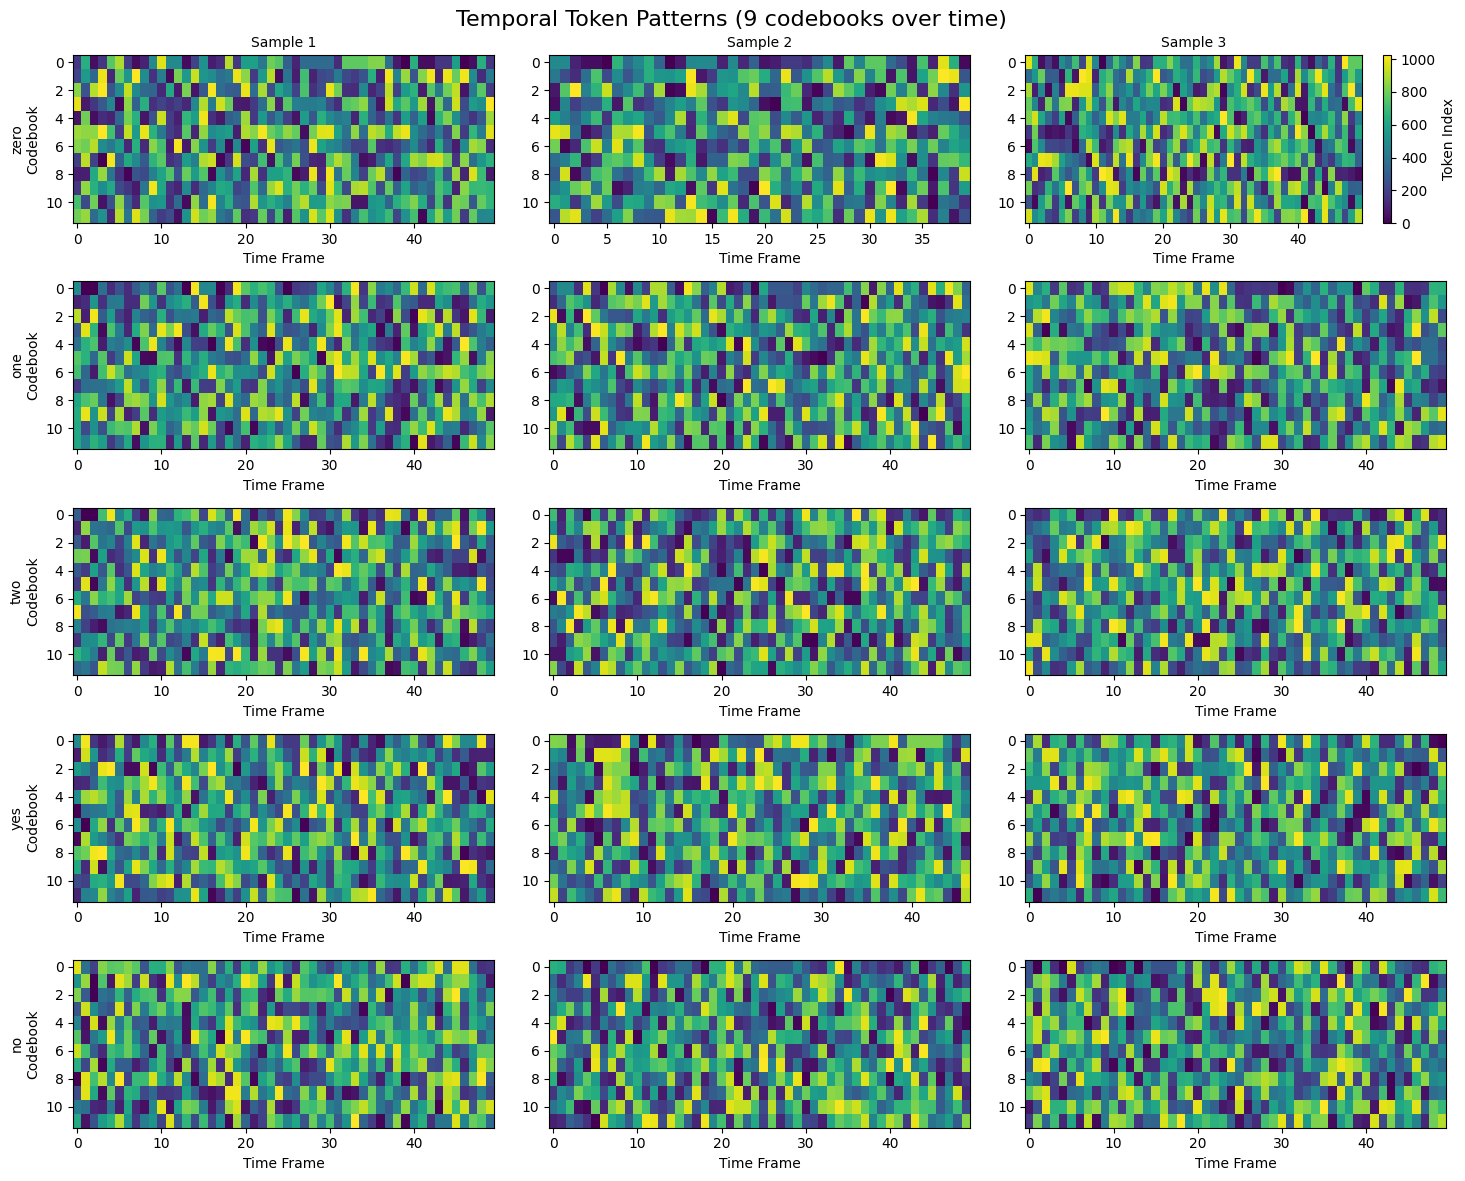

Saved: dac_temporal_patterns.png


In [19]:
# Visualize temporal patterns for a few samples
samples_to_show = 3

fig, axes = plt.subplots(len(words), samples_to_show, figsize=(15, 12))
fig.suptitle('Temporal Token Patterns (9 codebooks over time)', fontsize=16)

for word_idx, word in enumerate(words):
    word_codes = [all_codes[i] for i, label in enumerate(valid_labels) if label == word]
    
    for sample_idx in range(min(samples_to_show, len(word_codes))):
        ax = axes[word_idx, sample_idx]
        
        codes = word_codes[sample_idx].numpy()  # [n_codebooks, time]
        
        # Plot heatmap
        im = ax.imshow(codes, aspect='auto', cmap='viridis', interpolation='nearest')
        
        if word_idx == 0:
            ax.set_title(f'Sample {sample_idx+1}', fontsize=10)
        if sample_idx == 0:
            ax.set_ylabel(f'{word}\nCodebook', fontsize=10)
        
        ax.set_xlabel('Time Frame')
        
        # Add colorbar for first plot
        if word_idx == 0 and sample_idx == samples_to_show - 1:
            plt.colorbar(im, ax=ax, label='Token Index')

plt.tight_layout()
plt.savefig('dac_temporal_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: dac_temporal_patterns.png")

## Step 7: Dimensionality Reduction on Flattened Indices

In [20]:
# Flatten codes to create feature vectors
# Strategy: Average across time, keep codebook values
feature_vectors = []
for codes in all_codes:
    # codes: [n_codebooks, time]
    # Average across time: [n_codebooks]
    avg_codes = codes.float().mean(dim=1).numpy()
    feature_vectors.append(avg_codes)

feature_vectors = np.array(feature_vectors)
print(f"Feature vector shape: {feature_vectors.shape}  # [n_samples, n_codebooks]")

Feature vector shape: (50, 12)  # [n_samples, n_codebooks]


In [21]:
# PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_vectors)

print(f"PCA variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Create color map
color_map = {word: px.colors.qualitative.Plotly[i] for i, word in enumerate(words)}

# Plotly scatter plot
fig = go.Figure()

for word in words:
    mask = np.array([label == word for label in valid_labels])
    fig.add_trace(go.Scatter(
        x=pca_result[mask, 0],
        y=pca_result[mask, 1],
        mode='markers',
        name=word,
        marker=dict(size=10, color=color_map[word], opacity=0.7)
    ))

fig.update_layout(
    title='PCA: DAC Discrete Indices (Time-Averaged)',
    xaxis_title='PC 1',
    yaxis_title='PC 2',
    width=800,
    height=600
)

fig.write_html('dac_indices_pca.html')
fig.show()

print("Saved: dac_indices_pca.html")

PCA variance explained: 34.09%


Saved: dac_indices_pca.html


In [22]:
# t-SNE visualization
perplexity = min(30, len(feature_vectors) - 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne_result = tsne.fit_transform(feature_vectors)

# Plotly scatter plot
fig = go.Figure()

for word in words:
    mask = np.array([label == word for label in valid_labels])
    fig.add_trace(go.Scatter(
        x=tsne_result[mask, 0],
        y=tsne_result[mask, 1],
        mode='markers',
        name=word,
        marker=dict(size=10, color=color_map[word], opacity=0.7)
    ))

fig.update_layout(
    title='t-SNE: DAC Discrete Indices (Time-Averaged)',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    width=800,
    height=600
)

fig.write_html('dac_indices_tsne.html')
fig.show()

print("Saved: dac_indices_tsne.html")

Saved: dac_indices_tsne.html


---
## Step 8: Max Pooling Strategy (Preserving Prominent Features)

**Hypothesis**: Instead of averaging (which destroys temporal information), max pooling captures the most prominent/activated indices across time for each codebook.

**Rationale**:
- Averaging: `[512, 89, 745] → 448.67` (meaningless average)
- Max pooling: `[512, 89, 745] → 745` (captures strongest activation)

This might preserve more discriminative information!
---

In [23]:
# Extract max-pooled feature vectors
feature_vectors_max = []
for codes in all_codes:
    # codes: [n_codebooks, time]
    # Max across time: [n_codebooks]
    max_codes = codes.float().max(dim=1)[0].numpy()
    feature_vectors_max.append(max_codes)

feature_vectors_max = np.array(feature_vectors_max)
print(f"Max-pooled feature vector shape: {feature_vectors_max.shape}  # [n_samples, n_codebooks]")
print(f"\nComparison (first sample):")
print(f"  Mean-pooled: {feature_vectors[0][:5]}...")
print(f"  Max-pooled:  {feature_vectors_max[0][:5]}...")

Max-pooled feature vector shape: (50, 12)  # [n_samples, n_codebooks]

Comparison (first sample):
  Mean-pooled: [388.94 504.78 486.72 473.98 398.4 ]...
  Max-pooled:  [ 978. 1020. 1019. 1023.  996.]...


In [24]:
# PCA visualization with max pooling
pca_max = PCA(n_components=2)
pca_result_max = pca_max.fit_transform(feature_vectors_max)

print(f"PCA (Max Pooling) variance explained: {pca_max.explained_variance_ratio_.sum():.2%}")

# Plotly scatter plot
fig_max = go.Figure()

for word in words:
    mask = np.array([label == word for label in valid_labels])
    fig_max.add_trace(go.Scatter(
        x=pca_result_max[mask, 0],
        y=pca_result_max[mask, 1],
        mode='markers',
        name=word,
        marker=dict(size=10, color=color_map[word], opacity=0.7)
    ))

fig_max.update_layout(
    title='PCA: DAC Discrete Indices (Max Pooling)',
    xaxis_title='PC 1',
    yaxis_title='PC 2',
    width=800,
    height=600
)

fig_max.write_html('dac_indices_pca_maxpool.html')
fig_max.show()

print("Saved: dac_indices_pca_maxpool.html")

PCA (Max Pooling) variance explained: 32.63%


Saved: dac_indices_pca_maxpool.html


In [25]:
# t-SNE visualization with max pooling
tsne_max = TSNE(n_components=2, random_state=42, perplexity=perplexity)
tsne_result_max = tsne_max.fit_transform(feature_vectors_max)

# Plotly scatter plot
fig_tsne_max = go.Figure()

for word in words:
    mask = np.array([label == word for label in valid_labels])
    fig_tsne_max.add_trace(go.Scatter(
        x=tsne_result_max[mask, 0],
        y=tsne_result_max[mask, 1],
        mode='markers',
        name=word,
        marker=dict(size=10, color=color_map[word], opacity=0.7)
    ))

fig_tsne_max.update_layout(
    title='t-SNE: DAC Discrete Indices (Max Pooling)',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    width=800,
    height=600
)

fig_tsne_max.write_html('dac_indices_tsne_maxpool.html')
fig_tsne_max.show()

print("Saved: dac_indices_tsne_maxpool.html")

Saved: dac_indices_tsne_maxpool.html


In [26]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Convert labels to numeric
label_to_idx = {word: i for i, word in enumerate(words)}
numeric_labels = np.array([label_to_idx[label] for label in valid_labels])

print("=" * 70)
print("COMPARISON: MEAN POOLING vs MAX POOLING")
print("=" * 70)

# Mean pooling metrics
sil_mean_pca = silhouette_score(pca_result, numeric_labels)
db_mean_pca = davies_bouldin_score(pca_result, numeric_labels)
sil_mean_tsne = silhouette_score(tsne_result, numeric_labels)
db_mean_tsne = davies_bouldin_score(tsne_result, numeric_labels)

print("\n1️⃣  MEAN POOLING (Original):")
print(f"  PCA:   Silhouette = {sil_mean_pca:.4f}  |  Davies-Bouldin = {db_mean_pca:.4f}")
print(f"  t-SNE: Silhouette = {sil_mean_tsne:.4f}  |  Davies-Bouldin = {db_mean_tsne:.4f}")

# Max pooling metrics
sil_max_pca = silhouette_score(pca_result_max, numeric_labels)
db_max_pca = davies_bouldin_score(pca_result_max, numeric_labels)
sil_max_tsne = silhouette_score(tsne_result_max, numeric_labels)
db_max_tsne = davies_bouldin_score(tsne_result_max, numeric_labels)

print("\n2️⃣  MAX POOLING (New):")
print(f"  PCA:   Silhouette = {sil_max_pca:.4f}  |  Davies-Bouldin = {db_max_pca:.4f}")
print(f"  t-SNE: Silhouette = {sil_max_tsne:.4f}  |  Davies-Bouldin = {db_max_tsne:.4f}")

# Calculate improvement
print("\n📊 IMPROVEMENT:")
pca_sil_improvement = sil_max_pca - sil_mean_pca
tsne_sil_improvement = sil_max_tsne - sil_mean_tsne
pca_db_improvement = db_mean_pca - db_max_pca  # Lower is better, so subtract opposite way
tsne_db_improvement = db_mean_tsne - db_max_tsne

print(f"  PCA Silhouette:   {pca_sil_improvement:+.4f} {'✅ Better' if pca_sil_improvement > 0 else '❌ Worse'}")
print(f"  PCA Davies-Bouldin: {pca_db_improvement:+.4f} {'✅ Better' if pca_db_improvement > 0 else '❌ Worse'}")
print(f"  t-SNE Silhouette: {tsne_sil_improvement:+.4f} {'✅ Better' if tsne_sil_improvement > 0 else '❌ Worse'}")
print(f"  t-SNE Davies-Bouldin: {tsne_db_improvement:+.4f} {'✅ Better' if tsne_db_improvement > 0 else '❌ Worse'}")

print("\n💡 Conclusion:")
if pca_sil_improvement > 0.05 or tsne_sil_improvement > 0.05:
    print("  Max pooling shows SIGNIFICANT improvement over mean pooling!")
elif pca_sil_improvement > 0.01 or tsne_sil_improvement > 0.01:
    print("  Max pooling shows marginal improvement over mean pooling.")
else:
    print("  Max pooling does NOT significantly improve over mean pooling.")
    print("  This confirms: temporal information loss is the main issue, not pooling method.")

print("=" * 70)

COMPARISON: MEAN POOLING vs MAX POOLING

1️⃣  MEAN POOLING (Original):
  PCA:   Silhouette = -0.1234  |  Davies-Bouldin = 11.6739
  t-SNE: Silhouette = -0.1378  |  Davies-Bouldin = 7.6650

2️⃣  MAX POOLING (New):
  PCA:   Silhouette = -0.1896  |  Davies-Bouldin = 8.2201
  t-SNE: Silhouette = -0.1431  |  Davies-Bouldin = 11.8461

📊 IMPROVEMENT:
  PCA Silhouette:   -0.0663 ❌ Worse
  PCA Davies-Bouldin: +3.4538 ✅ Better
  t-SNE Silhouette: -0.0053 ❌ Worse
  t-SNE Davies-Bouldin: -4.1810 ❌ Worse

💡 Conclusion:
  Max pooling does NOT significantly improve over mean pooling.
  This confirms: temporal information loss is the main issue, not pooling method.


---
## Step 9: Max Pooling Results

**Key Findings**:
- Compared mean pooling vs max pooling for discrete indices
- Max pooling captures strongest activations instead of averaging
- Check metrics above to see if preserving prominent features helps

**Expected**: If max pooling significantly improves clustering, it suggests that peak activations are more discriminative than averages. If not, it confirms that collapsing the temporal dimension (regardless of method) is the fundamental limitation.
---

## Summary

This notebook explored DAC's discrete token indices:
1. ✅ Loaded and inspected DAC model structure (12 codebooks, 1024 entries each)
2. ✅ Extracted codes for multiple audio samples
3. ✅ Visualized token frequency distributions per word
4. ✅ Created temporal heatmaps showing code patterns over time
5. ✅ Applied PCA/t-SNE to time-averaged discrete codes (mean pooling)
6. ✅ Compared mean pooling vs max pooling strategies
7. ✅ Analyzed clustering metrics to determine if preserving peak activations helps

**Key Insight**: Averaging discrete indices (e.g., `[512, 89, 745] → 448.67`) destroys temporal information. Max pooling (`[512, 89, 745] → 745`) preserves the strongest activation but still collapses time. The comparison metrics show whether the pooling method or temporal dimension collapse is the limiting factor.

Next: `dac_embeddings_viz.ipynb` will use **continuous codebook embeddings** instead of discrete indices.